In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wrangle
import prep
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

wrangle.py functions loaded successfully
acquire.py functions loaded successfully


In [2]:
df = prep.prep_zillow_data()
df.describe()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,propertylandusetypeid
count,21352.000000,21352.000000,21352.000000,21352.000000,21352.000000,21352.000000,21352.000000,2.135200e+04,2.135200e+04,2.135200e+04,...,21352.000000,21352.000000,21352.000000,21352.000000,2.131600e+04,2.135200e+04,21352.0,2.135200e+04,21351.000000,21352.000000
mean,2.304632,3.061727,2.322734,1800.447152,6049.393125,2.252219,3.955741,3.400427e+07,-1.182018e+08,2.745509e+04,...,96604.933265,1.543837,1.108271,1968.261201,1.917828e+05,5.030912e+05,2016.0,3.116318e+05,6138.545271,261.675909
std,0.994982,1.130032,0.973808,944.553063,21.135638,0.958671,2.834390,2.670335e+05,3.616733e+05,8.690801e+04,...,4169.486264,2.878904,0.370724,23.837674,2.369039e+05,6.505557e+05,0.0,4.688036e+05,7545.612209,3.805794
min,0.000000,0.000000,1.000000,242.000000,6037.000000,1.000000,1.000000,3.334085e+07,-1.193883e+08,4.350000e+02,...,95982.000000,0.000000,1.000000,1824.000000,1.290000e+02,1.050400e+04,2016.0,2.250000e+03,19.920000,246.000000
25%,2.000000,2.000000,2.000000,1188.750000,6037.000000,2.000000,2.000000,3.380747e+07,-1.184140e+08,5.994750e+03,...,96193.000000,0.000000,1.000000,1953.000000,8.496000e+04,2.108100e+05,2016.0,8.780000e+04,2739.735000,261.000000
50%,2.000000,3.000000,2.000000,1557.000000,6037.000000,2.000000,3.955741,3.401928e+07,-1.181780e+08,7.600000e+03,...,96395.000000,0.000000,1.000000,1969.000000,1.386090e+05,3.652830e+05,2016.0,2.091910e+05,4523.300000,261.000000
75%,3.000000,4.000000,3.000000,2137.000000,6059.000000,3.000000,3.955741,3.417543e+07,-1.179231e+08,2.028750e+04,...,96987.000000,0.000000,1.108271,1987.000000,2.220000e+05,5.885595e+05,2016.0,3.812392e+05,7139.870000,265.000000
max,11.000000,12.000000,11.000000,15450.000000,6111.000000,11.000000,24.000000,3.477966e+07,-1.175554e+08,3.589145e+06,...,399675.000000,14.000000,4.000000,2015.000000,7.893568e+06,2.385837e+07,2016.0,1.635060e+07,276797.830000,275.000000


In [3]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.train_validate_test(df)

In [4]:
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.min_max_scale(X_train, X_validate, X_test)

In [5]:
X_train_scaled

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt
3927,0.272727,0.166667,0.20,0.182322,0.1
19745,0.090909,0.166667,0.00,0.043299,0.0
1732,0.227273,0.250000,0.15,0.103328,0.1
17739,0.272727,0.250000,0.20,0.125783,0.2
15673,0.090909,0.250000,0.00,0.063697,0.0
...,...,...,...,...,...
11371,0.181818,0.166667,0.10,0.063607,0.1
21006,0.272727,0.250000,0.20,0.106280,0.2
20936,0.272727,0.416667,0.20,0.197531,0.2
3675,0.090909,0.250000,0.00,0.069959,0.0


In [6]:
from sklearn.feature_selection import SelectKBest, f_regression

In [7]:
f_selector = SelectKBest(f_regression, k=5)

In [8]:
f_selector = f_selector.fit(X_train_scaled, y_train.taxvaluedollarcnt)

In [9]:
X_train_reduced = f_selector.transform(X_train_scaled)
print(X_train.shape)
print(X_train_reduced.shape)

(11956, 5)
(11956, 5)


In [10]:
f_support = f_selector.get_support()
f_support

array([ True,  True,  True,  True,  True])

In [11]:
f_feature = X_train_scaled.iloc[:, f_support].columns.tolist()
f_feature

['bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'fullbathcnt']

In [12]:
X_reduced_scaled = X_train_scaled.iloc[:, f_support]
X_reduced_scaled.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt
3927,0.272727,0.166667,0.20,0.182322,0.1
19745,0.090909,0.166667,0.00,0.043299,0.0
1732,0.227273,0.250000,0.15,0.103328,0.1
17739,0.272727,0.250000,0.20,0.125783,0.2
15673,0.090909,0.250000,0.00,0.063697,0.0


In [13]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [14]:
lm = LinearRegression()

rfe = RFE(lm, 5)

X_rfe = rfe.fit_transform(X_train,y_train) 

In [15]:
mask = rfe.support_ 
rfe_features = X_train.columns[mask]
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 5 features: bathroomcnt, bedroomcnt, calculatedbathnbr, calculatedfinishedsquarefeet, fullbathcnt


In [16]:
lm.fit(X_rfe, y_train)

LinearRegression()

In [17]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", rfe_features)

print("coefficients: ", lm.coef_)

Linear Model: LinearRegression()
intercept:  [-28255.94186279]
features:  Index(['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fullbathcnt'],
      dtype='object')
coefficients:  [[ 256829.62604386 -151962.38796133 -308699.92064149     501.3743033
    99790.60451672]]


In [18]:
y_train['yhat_lm'] = lm.predict(X_rfe)

y_train.head()

,taxvaluedollarcnt,yhat_lm
3927,798178.0,884002.728581
19745,543907.0,108817.045925
1732,604073.0,315261.978101
17739,153848.0,514962.385448
15673,30802.0,71167.999117


In [19]:
RMSE_lm = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_lm))
RMSE_lm

566770.4859859975

In [20]:
y_train['yhat_lm'] = lm.predict(X_rfe)

y_train.head()

,taxvaluedollarcnt,yhat_lm
3927,798178.0,884002.728581
19745,543907.0,108817.045925
1732,604073.0,315261.978101
17739,153848.0,514962.385448
15673,30802.0,71167.999117


In [21]:
r2_lm = lm.score(X_rfe, y_train.taxvaluedollarcnt)

r2_lm

0.35154975172469793

In [22]:
output = "{} = {:.4} + {:.2} * {} + {:.3} * {}".format(
    y_train.columns[0],
    lm.intercept_[0],
    lm.coef_[0][0],
    rfe_features[0],
    lm.coef_[0][1],
    rfe_features[1],
)
output

'taxvaluedollarcnt = -2.826e+04 + 2.6e+05 * bathroomcnt + -1.52e+05 * bedroomcnt'

In [23]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_rfe)

poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2']

In [24]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.taxvaluedollarcnt)
y_train['yhat_poly'] = lm_poly.predict(X_poly)

In [25]:
RMSE_poly = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_poly))
RMSE_poly

535094.5087927479

In [26]:
y_train.head()

,taxvaluedollarcnt,yhat_lm,yhat_poly
3927,798178.0,884002.728581,473861.142674
19745,543907.0,108817.045925,259696.332001
1732,604073.0,315261.978101,431628.531054
17739,153848.0,514962.385448,474789.037395
15673,30802.0,71167.999117,256245.930058


In [27]:
y_train['yhat_baseline'] = df['taxvaluedollarcnt'].mean()

# compute the RMSE
RMSE_bl = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_baseline))
print(RMSE_bl)

# no need to compute R-2 because it will be a 0! But we will demonstrate here:
evs = explained_variance_score(y_train.taxvaluedollarcnt, y_train.yhat_baseline)
print(evs)


703880.4241372065
1.1102230246251565e-16


In [28]:
y_train.head()

,taxvaluedollarcnt,yhat_lm,yhat_poly,yhat_baseline
3927,798178.0,884002.728581,473861.142674,503091.195579
19745,543907.0,108817.045925,259696.332001,503091.195579
1732,604073.0,315261.978101,431628.531054,503091.195579
17739,153848.0,514962.385448,474789.037395,503091.195579
15673,30802.0,71167.999117,256245.930058,503091.195579


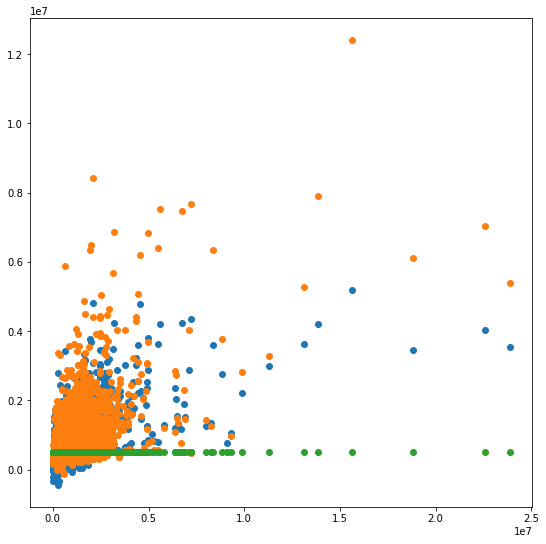

In [29]:
plt.figure(figsize=(9, 9))

plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_lm, marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_poly, marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_baseline, marker='o')